In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

### Hand detection

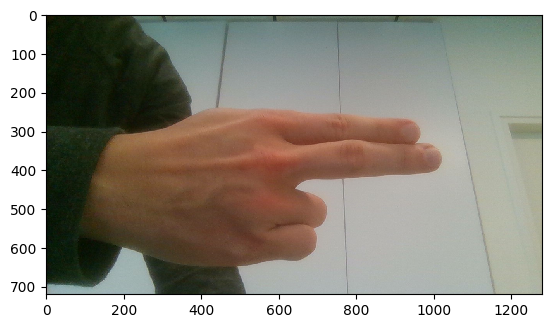

In [2]:
img = cv2.imread("data/segmentation/H_proche.jpg", 1)
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb, interpolation="nearest")
plt.show()

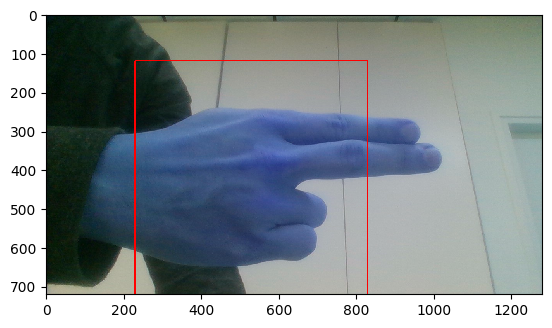

In [3]:
x, y, w, h = 100, 100, 600, 600  # simply hardcoded the values
track_window = (x, y, w, h)

roi = img[y : y + h, x : x + w]
hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(
    hsv_roi, np.array((0.0, 60.0, 32.0)), np.array((180.0, 255.0, 255.0))
)
roi_hist = cv2.calcHist([hsv_roi], [0], mask, [180], [0, 180])
cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
dst = cv2.calcBackProject([hsv], [0], roi_hist, [0, 180], 1)

term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 100, 1)
ret, track_window = cv2.meanShift(dst, track_window, term_crit)

x, y, w, h = track_window
img2 = cv2.rectangle(img, (x, y), (x + w, y + h), 255, 2)
plt.imshow(img2, interpolation="nearest")

# we could first segment the position of the hand by constraining its position on the photo and then only try to get interest points

### contrast

In [4]:
img1 = cv2.imread("data/B_real2.jpg", 1)
img2 = cv2.imread("data/labels/F.jpg", 1)

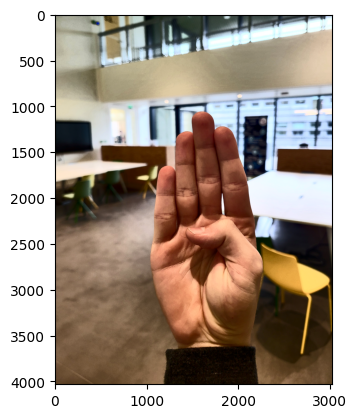

In [5]:
def equalize(img):
    lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    l_channel_equalized = cv2.equalizeHist(l_channel)
    lab_image_equalized = cv2.merge((l_channel_equalized, a_channel, b_channel))
    output_image = cv2.cvtColor(lab_image_equalized, cv2.COLOR_LAB2RGB)
    return output_image


plt.imshow(equalize(img1))
# plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

### reduce image quality

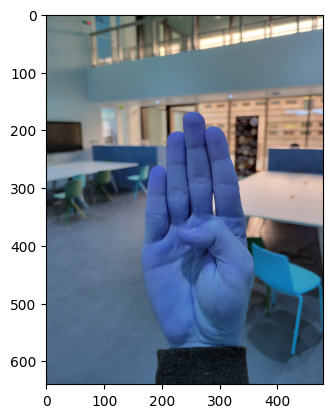

In [6]:
img1 = cv2.imread("data/B_real2.jpg", 1)
img2 = cv2.imread("data/labels/F.jpg", 1)


def resize_to_max(img, max_size_value=640):
    max_size = max(img.shape[0], img.shape[1])
    ratio = max_size_value / max_size
    target_resolution = (int(img.shape[1] * ratio), int(img.shape[0] * ratio))
    resized_image = cv2.resize(img, target_resolution)
    return resized_image


resized_image = resize_to_max(img1)
plt.imshow(resized_image)

### skin detection

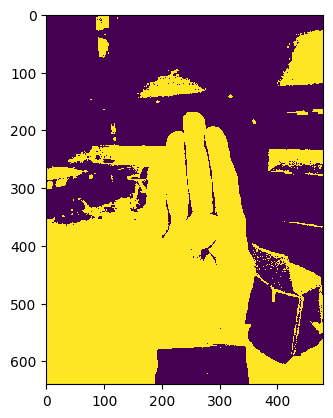

In [7]:
# Approche classique avec parcours de l'image
def isSkin(pixel):
    b = pixel[0]
    g = pixel[1]
    r = pixel[2]
    c1 = r > 95
    c2 = g > 40
    c3 = b > 20
    c4 = max(pixel) - min(pixel) > 15
    c4 = abs(int(r) - int(g)) > 15
    c5 = r > g
    c6 = r > b
    isSkin = c1 and c2 and c3 and c4 and c5 and c6
    return isSkin


def createSkinMask(img):
    height, width = img.shape[:2]
    mask = np.zeros((height, width), np.uint8)
    for i in range(height):
        for j in range(width):
            if isSkin(img[i][j]):
                mask[i][j] = 255
    return mask


skinMask = createSkinMask(resized_image)
plt.imshow(skinMask, interpolation="nearest")

### matching

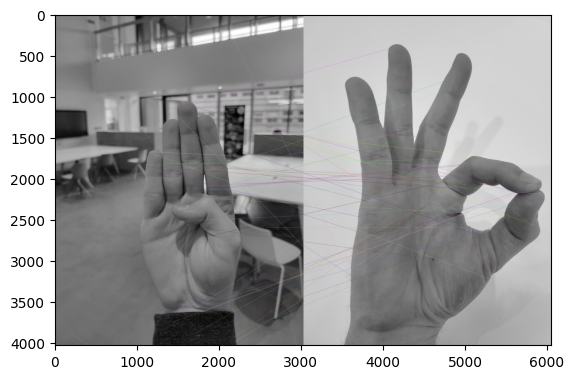

(<matplotlib.image.AxesImage at 0x16bce15b0>, None)

In [8]:
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# sift
sift = cv2.SIFT_create()


keypoints_1, descriptors_1 = sift.detectAndCompute(img1, mask=skinMask)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2, mask=skinMask)

bf = cv2.BFMatcher(crossCheck=True)

matches = bf.match(descriptors_1, descriptors_2)
matches = sorted(matches, key=lambda x: x.distance)

img3 = cv2.drawMatches(
    img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2
)
plt.imshow(img3), plt.show()

In [9]:
def classify(img, labels_directory, mask_1):

    liste_len_matching = {}
    sift = cv2.SIFT_create()  # we could also use ORB but I dont think it work better
    bf = cv2.BFMatcher(crossCheck=True)  # we can specify another norm than L2

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keypoints_1, descriptors_1 = sift.detectAndCompute(img, mask=mask_1)

    height, width = img.shape[:2]

    for filename in os.listdir(labels_directory):
        img_path = os.path.join(labels_directory, filename)
        img_label = cv2.imread(img_path)
        img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2GRAY)
        # Resize the label image before detecting keypoints
        img_label_resized = cv2.resize(img_label, (width, height))
        keypoints_2, descriptors_2 = sift.detectAndCompute(img_label_resized, mask=None)
        matches = bf.match(descriptors_1, descriptors_2)
        liste_len_matching[filename] = len(matches)

        matches = sorted(matches, key=lambda x: x.distance)

        # Draw the top 50 matches on the resized label image
        img_matches = cv2.drawMatches(
            img,
            keypoints_1,
            img_label_resized,
            keypoints_2,
            matches[:50],
            None,
            flags=2,
        )

        # Display the matching keypoints
        plt.imshow(img_matches), plt.show()

    chosen = max(liste_len_matching, key=lambda k: liste_len_matching[k])
    return chosen, liste_len_matching

In [10]:
chosen, liste_len_matching = classify("data/F_real.jpg", "data/labels/")

TypeError: classify() missing 1 required positional argument: 'mask_1'

In [11]:
def classify_knn(img_path, labels_directory):  # Works worse than the previous one

    liste_len_matching = {}
    sift = cv2.SIFT_create(
        nfeatures=1000
    )  # we could also use ORB but I dont think it work better
    bf = cv2.BFMatcher()  # we can specify another norm than L2

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keypoints_1, descriptors_1 = sift.detectAndCompute(img, None)

    for filename in os.listdir(labels_directory):
        img_path = os.path.join(labels_directory, filename)
        img_label = cv2.imread(img_path)
        img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2GRAY)
        keypoints_2, descriptors_2 = sift.detectAndCompute(img_label, None)
        matches = bf.knnMatch(
            np.array(descriptors_1, dtype=np.float32),
            np.array(descriptors_2, dtype=np.float32),
            k=2,
        )
        good = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good.append([m])
        liste_len_matching[filename] = len(good)
    chosen = max(liste_len_matching, key=lambda k: liste_len_matching[k])
    return chosen, liste_len_matching

### full pipeline

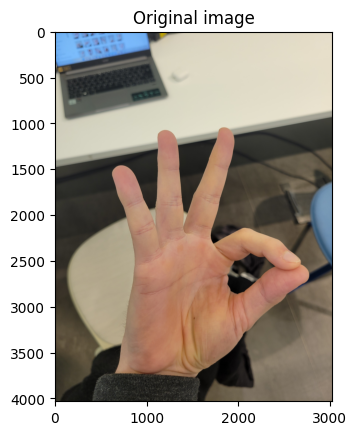

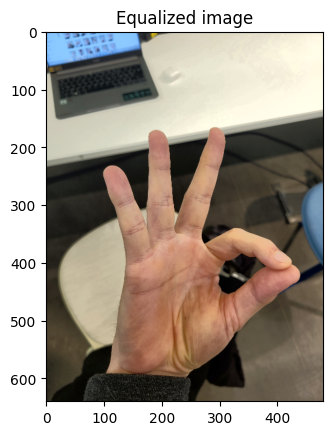

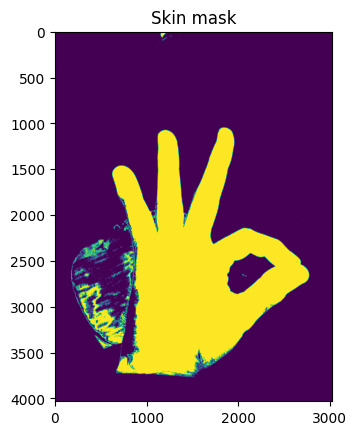

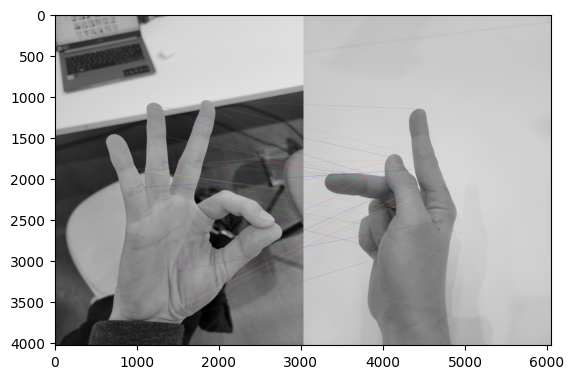

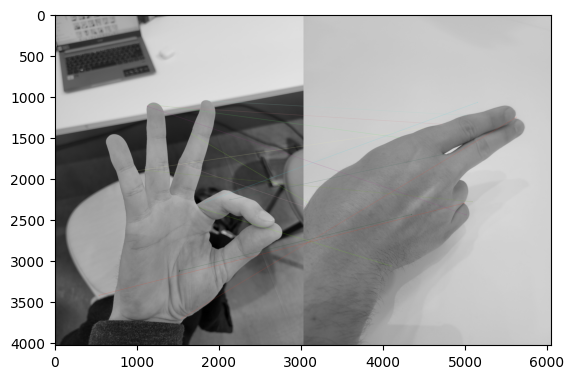

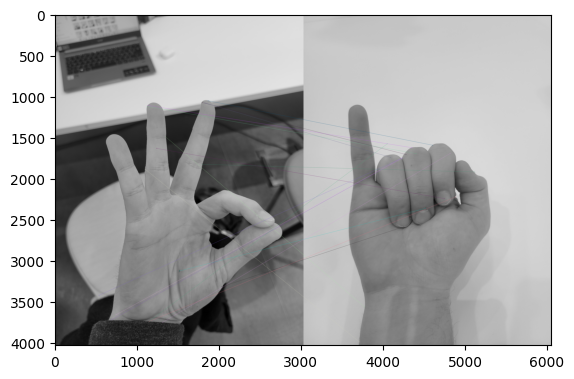

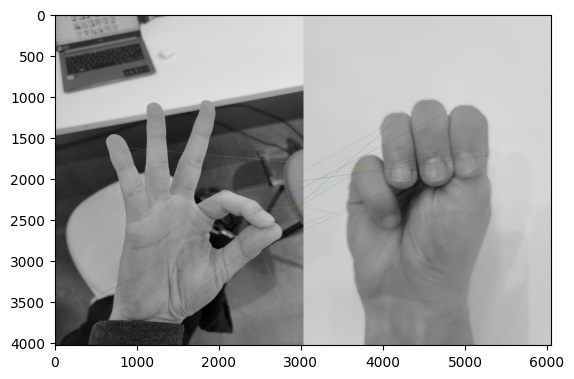

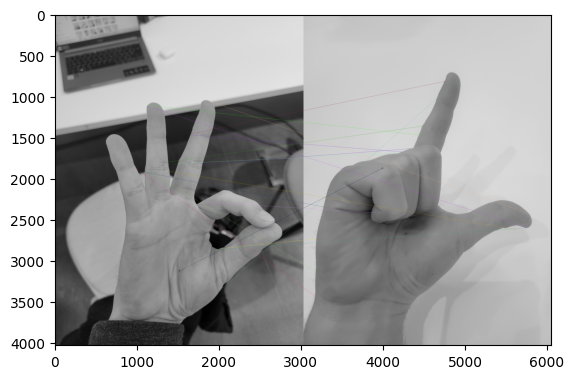

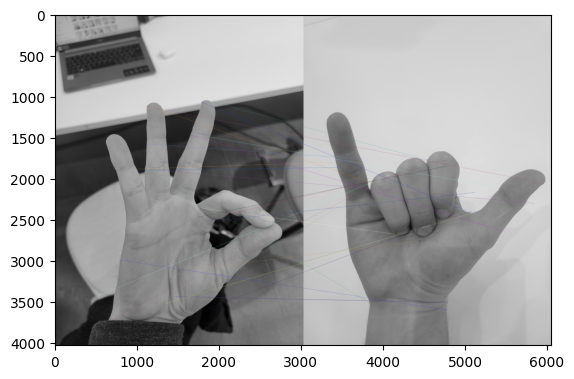

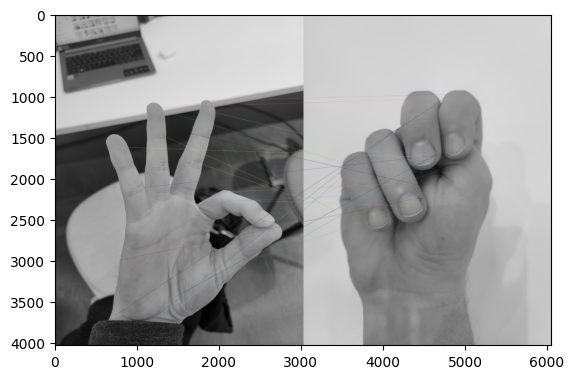

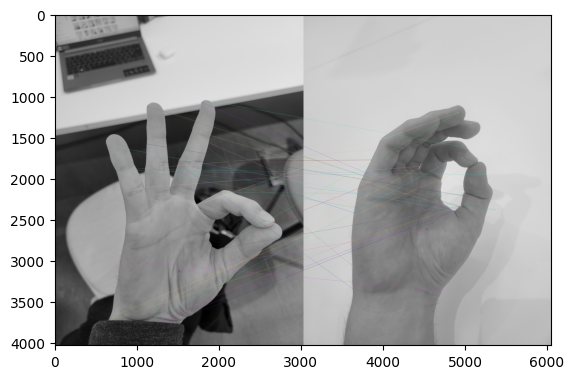

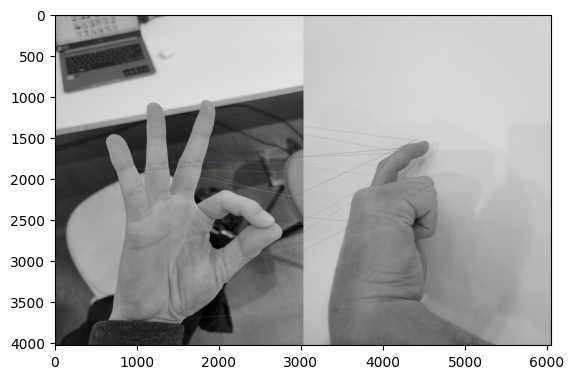

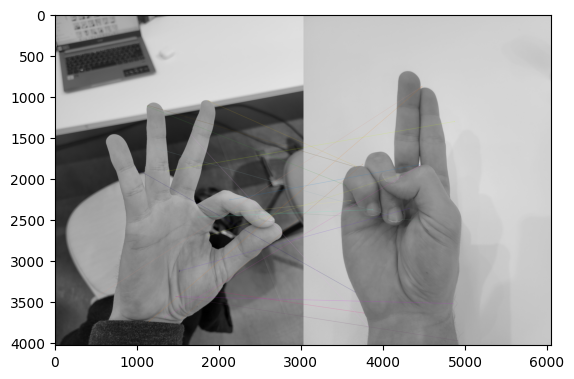

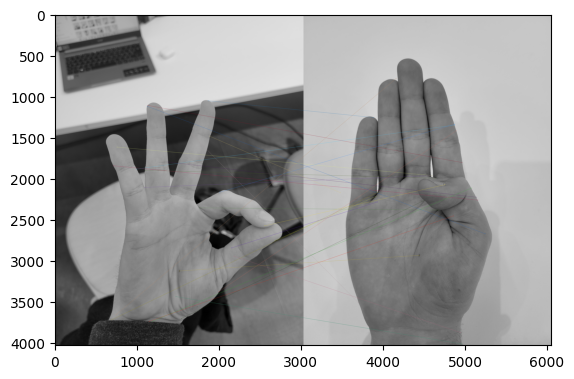

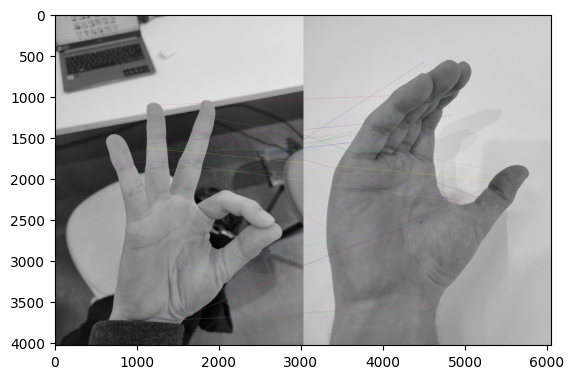

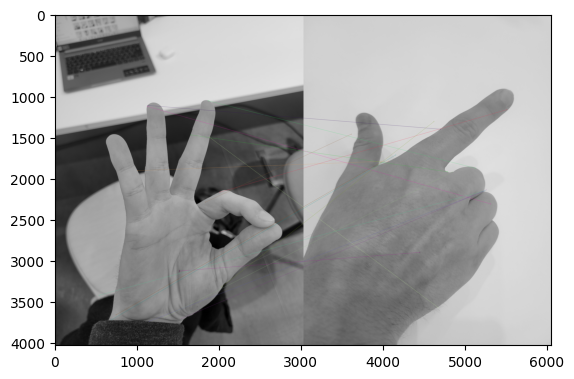

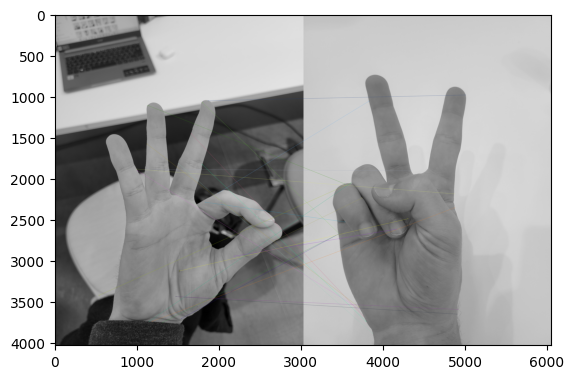

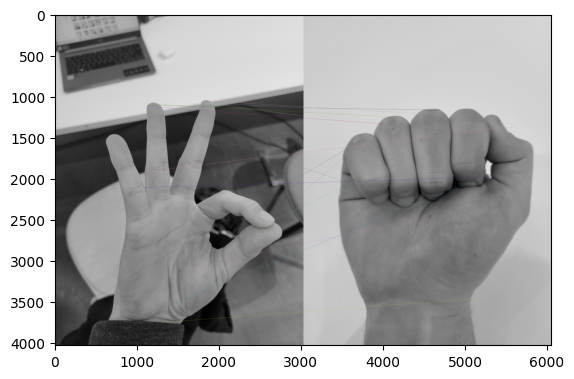

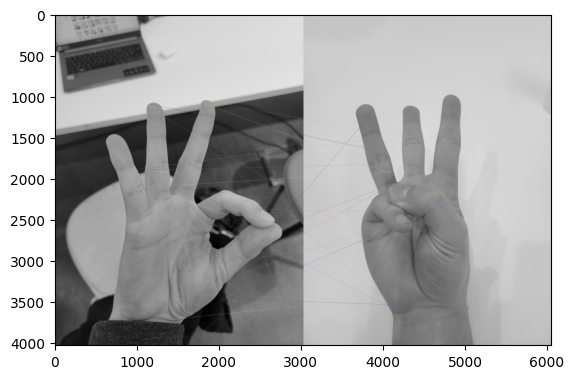

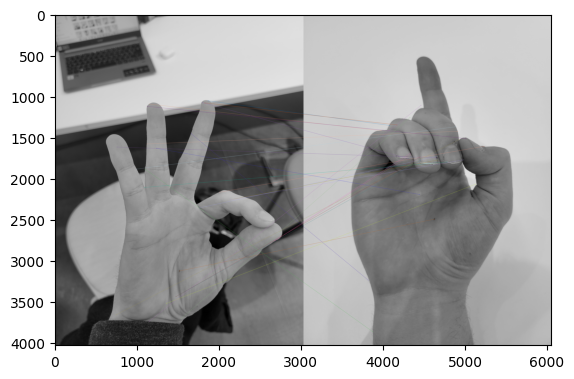

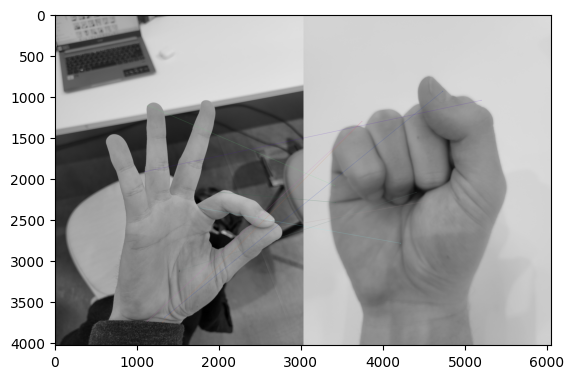

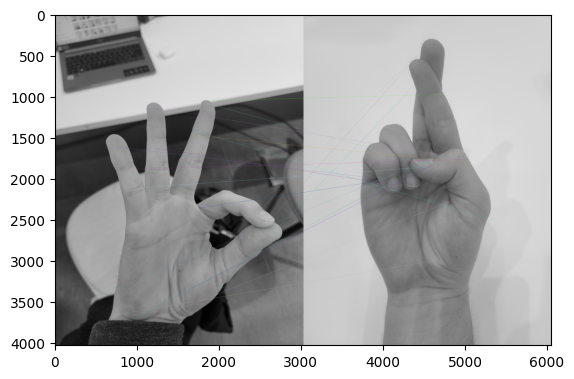

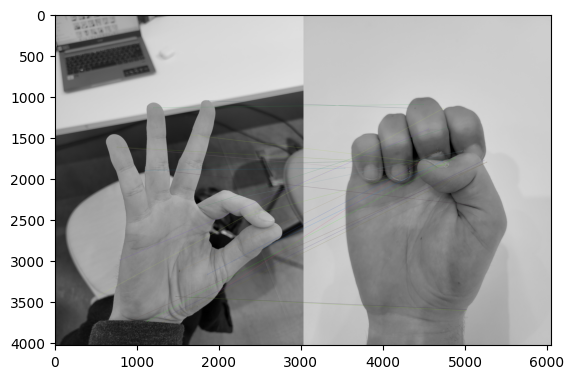

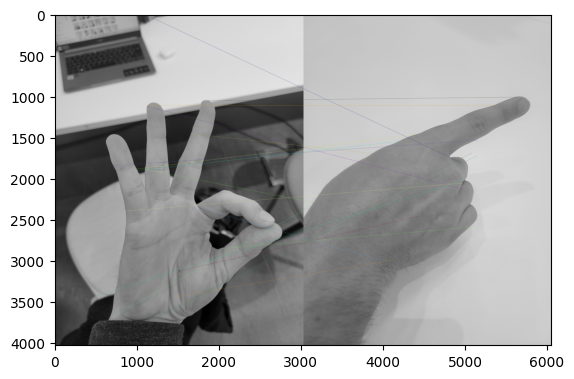

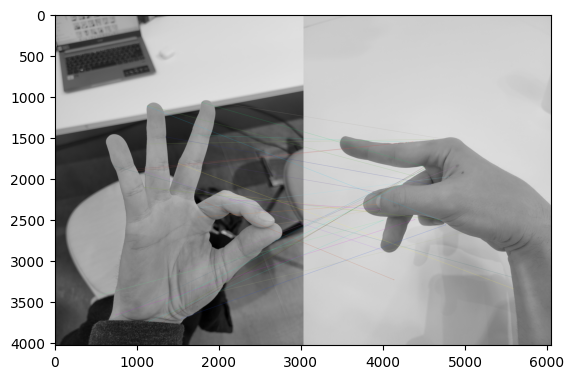

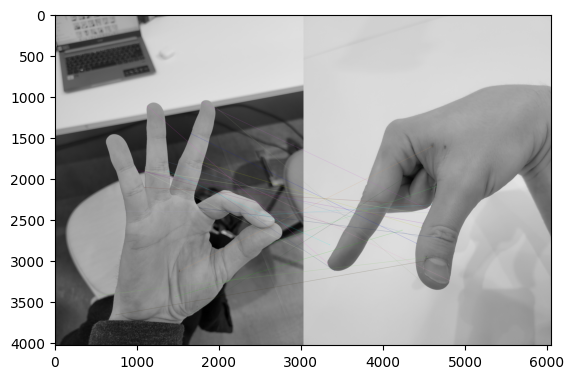

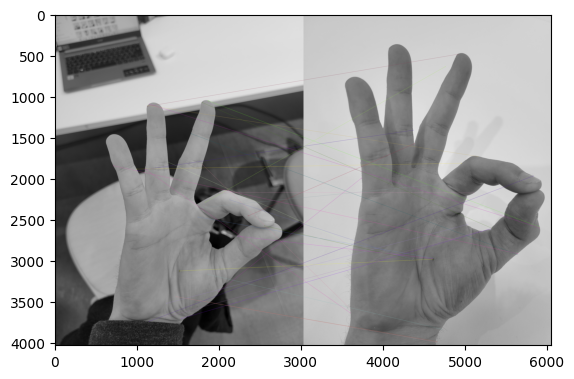

In [13]:
# TODO : also preprocess the label image
# TODO : put the right skin detector technique
from create_skin_mask import createSkinMask


def full_pipeline(img_path, labels_directory, max_size_value):
    img = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original image")
    plt.show()
    resized_image = resize_to_max(img, max_size_value)
    equalized_image = equalize(resized_image)
    plt.imshow(equalized_image)
    plt.title("Equalized image")
    plt.show()
    skin_mask = createSkinMask(
        img=img, histogram_file="histogram.plk", color_space="BGR", size=32
    )
    plt.imshow(skin_mask)
    plt.title("Skin mask")
    plt.show()
    chosen, liste_len_matching = classify(img, labels_directory, skin_mask)
    return chosen, liste_len_matching


chosen, liste_len_matching = full_pipeline(
    "data/F_real.jpg", "data/labels/", max_size_value=640
)

In [14]:
chosen

'K.jpg'

In [19]:
results = sorted(liste_len_matching.items(), key=lambda x: x[1], reverse=True)
results

[('K.jpg', 34),
 ('O.jpg', 32),
 ('P.jpg', 31),
 ('F.jpg', 29),
 ('B.jpg', 26),
 ('D.jpg', 26),
 ('Y.jpg', 25),
 ('N.jpg', 23),
 ('C.jpg', 23),
 ('E.jpg', 23),
 ('Q.jpg', 23),
 ('V.jpg', 22),
 ('U.jpg', 20),
 ('X.jpg', 19),
 ('W.jpg', 18),
 ('R.jpg', 18),
 ('G.jpg', 18),
 ('I.jpg', 17),
 ('L.jpg', 17),
 ('T.jpg', 17),
 ('A.jpg', 15),
 ('H.jpg', 14),
 ('M.jpg', 14),
 ('S.jpg', 9)]